In [1]:
import numpy as np
import torch
from numba import jit
import sys
sys.path.append('/pasteur/appa/homes/ahabis/1-Click_project')
from config import *
import time
from glob import glob
import tifffile
from tqdm import tqdm

cosine_similarities = np.load("pairwise_distances"+str(parameters["n_embedding"])+"_"+str(parameters["contractive"])+".npy")
def count_occurrences(arr1, arr2):
    unique_elements, counts = np.unique(arr2, return_counts=True)
    index_mapping = dict(zip(unique_elements, counts))

    # Count occurrences of elements in arr1 using the mapping
    occurrences = np.array([index_mapping.get(element, 0) for element in arr1])

    return occurrences
sort_array = np.argsort(-(cosine_similarities +1), axis=-1)

In [2]:
### Get the name of all the anchor patches
arr_filenames = np.array([os.path.basename(x) for x in glob(path_twins+'/*.tif')])
arr = np.char.find(arr_filenames, 'twin')
indexes_anchor = np.argwhere(arr==-1).flatten()
filename_anchor = arr_filenames[indexes_anchor]

In [3]:
x = [20,50,100,200,1000,2000,5000,10000,20000]
u = np.zeros((len(filename_anchor), len(x)))
for j, closests in enumerate(x):
    for i, filename in enumerate(filename_anchor):
        filename = filename_anchor[i].split('.')[0]
        indexes_twin = np.argwhere(np.char.find(arr_filenames, filename+'_twin')>=0).flatten()
        index_anchor = indexes_anchor[i]
        first_n_closest = sort_array[:,:closests][index_anchor]
        print(count_occurrences(indexes_twin,first_n_closest))
        u[i,j] = np.sum(count_occurrences(indexes_twin,first_n_closest))/20

[0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
[0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1]
[0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]
[0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0]
[0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1]
[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]
[0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1]
[0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0]
[1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0]
[0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1]
[0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1]
[1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0]
[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1]
[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1]
[1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1]
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0]
[0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0

In [4]:
x512 = np.mean(u, axis = 0)

In [5]:
print(x512)

[0.31028668 0.34624789 0.38284148 0.42407251 0.58064924 0.6836425
 0.83575042 0.93827993 0.99536256]


In [4]:
x256 = np.mean(u, axis = 0)

In [5]:
print(x256)

[0.3453204  0.36871838 0.39177909 0.42166948 0.54127319 0.6260118
 0.76332209 0.88157673 0.98490725]


In [4]:
x128 = np.mean(u, axis = 0)

In [5]:
print(x128)

[0.38954469 0.41833895 0.44363406 0.47976391 0.631914   0.71682125
 0.84371838 0.93452782 0.99363406]


In [6]:
df = pd.DataFrame(columns=['nb_twin', 'closest patches','contractive','n_embedding'])
n = np.array(x).shape[0]
closest = np.repeat(np.array(x)[:,None],6,-1).T.flatten()
contractive = np.concatenate([1e-5 * np.ones(n*3),1e-4 * np.ones(n*3)])
tmp1 = np.concatenate([128 * np.ones(n),256 * np.ones(n), 512 * np.ones(n)])
tmp2 = np.concatenate([128 * np.ones(n),256 * np.ones(n), 512 * np.ones(n)])

embedding = np.concatenate([tmp1,tmp2])
x1285 = np.array([0.38954469, 0.41833895, 0.44363406, 0.47976391, 0.631914, 0.71682125, 0.84371838, 0.93452782, 0.99363406])
x1284 = np.array([0.48979764, 0.52955312, 0.56387015, 0.60324621, 0.74418212, 0.81876054, 0.91408094, 0.96909781, 0.99789207])
x2565 = np.array([0.3453204 , 0.36871838, 0.39177909, 0.42166948, 0.54127319, 0.6260118, 0.76332209, 0.88157673, 0.98490725])
x2564 = np.array([0.33996627, 0.36682125, 0.39177909, 0.42525295, 0.55215008, 0.63499157, 0.77605396, 0.89262226, 0.98676223])
x5125 = np.array([0.31028668, 0.34624789, 0.38284148, 0.42407251, 0.58064924, 0.6836425, 0.83575042, 0.93827993, 0.99536256])
x5124 = np.array([0.31943508, 0.35885329, 0.39540472, 0.43908094, 0.60636594, 0.70181282, 0.84447723, 0.94173693, 0.99519393])

twin = np.concatenate([x1285, x2565, x5125, x1284, x2564, x5124])
# print(closest)
df['% of retrieved twins'] = twin
df['closest patches']= closest
df['n_embedding']= embedding.astype(np.int16)
df['contractive']= contractive

In [7]:
import seaborn as sns

In [8]:
import matplotlib.pyplot as plt

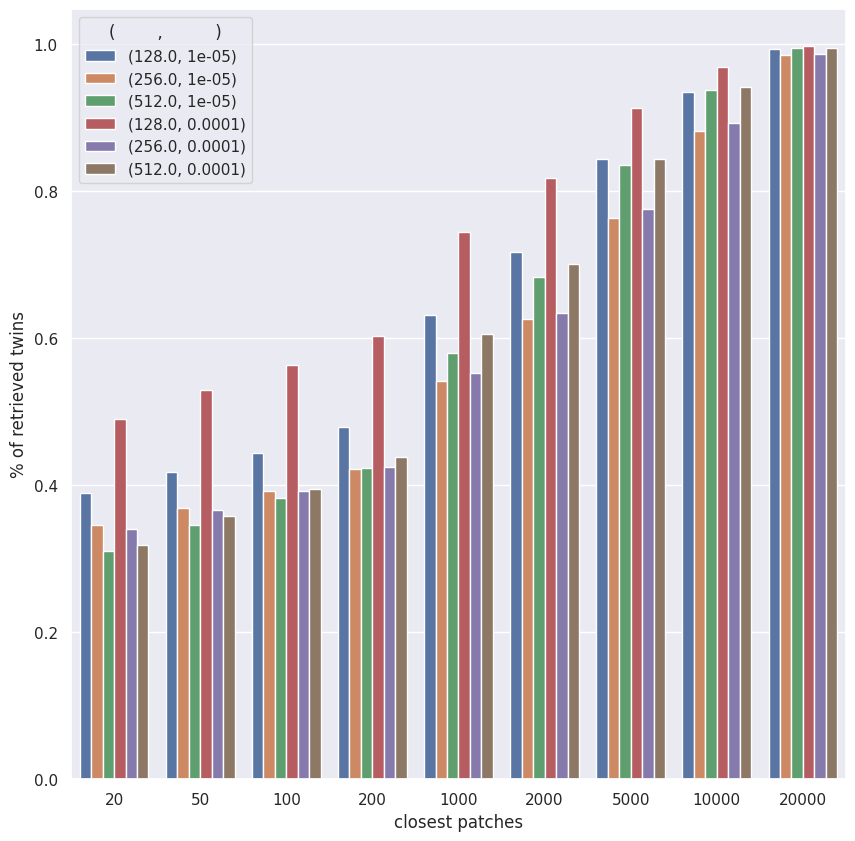

In [9]:
plt.figure(figsize = (10,10))
# plt.rcParams['text.usetex'] = True
# sns.set(font_scale=1.5)

sns.set(font_scale=5)

# sns.set_style("dark")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

sns.set_theme()

sns.barplot(data=df, x="closest patches", y="% of retrieved twins", hue=df[['n_embedding', 'contractive']].apply(tuple, axis=1))
# plt.xlabel("closest patches", fontsize=20)
# plt.ylabel("% of retrieved twins", fontsize=20)
# plt.title('% of retrieved twins among the n closest patches when varying   and     ', fontsize=20)
# sns.set_context("talk")

plt.legend(title='(        ,          )')
# plt.fontsize=50
# sinplot()